# Preparation of models and data

### Generator (GPT-2), Retriever (Sentence Transformer)

In [ ]:
# Install the latest transformers library
!pip install transformers -U
!pip3 install faiss-gpu

# # Download the DailyDialog dataset
# !wget https://www.dropbox.com/scl/fi/ai4je7bp3difjeuyk3a8s/dailydialog.json?rlkey=fe6pm2iz7nsb5fwulsjch5qzy -O dailydialog.json

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModel, AutoTokenizer
import torch
import shutil
import faiss
import numpy as np
import os
import gc
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
##GPT2- Generator
# Load a GPT2 tokenizer
generator_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Add special token <SEP> and <PAD>
generator_tokenizer.add_special_tokens({"sep_token": "<SEP>", "pad_token": "<PAD>"})

generator_model = GPT2LMHeadModel.from_pretrained('gpt2')
generator_model.resize_token_embeddings(len(generator_tokenizer))

##Sentence Transformer- Retriever #maximum length of input is 512
retriever_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
retriever_tokenizer.add_special_tokens({"sep_token": "<SEP>", "pad_token": "<PAD>"})
#30524
retriever_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
retriever_model.resize_token_embeddings(len(retriever_tokenizer))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(30524, 384, padding_idx=0)

In [ ]:
# Load the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
generator_model = generator_model.to(device)
retriever_model = retriever_model.to(device)

cuda


### Passages with pubtator search

In [ ]:
import requests
import json
import re

In [ ]:
def get_string_after(substring, text):
    parts = text.split(substring, 1)  # Split at the first occurrence of substring
    if len(parts) > 1:
        return parts[1]  # Return the text after the substring
    else:
        return None

def query_to_pmids(query, page_num=1):
    #Part 1. query to list of pmids
    pmids=[]
    for i in range(page_num):
        url="https://www.ncbi.nlm.nih.gov/research/pubtator3-api/search/?text="+query+"&page="+str(i+1)
        response = requests.get(url)
        json_dict=json.loads(response.text)
        for j in range(len(json_dict['results'])):
            pmids.append(json_dict['results'][j]['pmid'])
    return pmids

def pmid_to_text(pmid):
    url="https://www.ncbi.nlm.nih.gov/research/pubtator3-api/publications/export/pubtator?pmids="+str(pmid)
    response = requests.get(url)
    data_lines=response.text.splitlines()
    text=get_string_after('|a|',data_lines[1])
    return text

In [ ]:
pmids=query_to_pmids('Breast Cancer',10)
passages=[text for x in pmids if len(text:=pmid_to_text(x))>5]
print(len(passages))

72


(array([13., 12., 10., 28.,  6.,  2.,  0.,  0.,  0.,  1.]),
 array([ 67. , 126.2, 185.4, 244.6, 303.8, 363. , 422.2, 481.4, 540.6,
        599.8, 659. ]),
 <BarContainer object of 10 artists>)

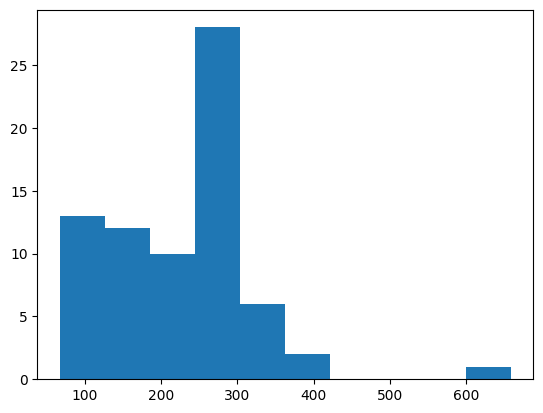

In [ ]:
import matplotlib.pyplot as plt
length_text=[len(text.split(' ')) for text in passages]
plt.hist(length_text)
#Most of them are shorter than 512 words
#In terms of token, the text can be longer but it seems okay

# Define necessary functions

In [ ]:
def text_embedder(texts, model, tokenizer):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    inputs.to(device)

    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state[:,0,:]
    return embeddings.cpu().numpy()

In [ ]:
passage_embeddings = text_embedder(passages, retriever_model, retriever_tokenizer, )
# 72 x 384
index = faiss.IndexFlatL2(passage_embeddings.shape[1])
#Build FAISS index for passage embeddings
index.add(passage_embeddings)

In [ ]:
passage_embeddings.shape

(72, 384)

In [ ]:
def retrieve_passages(query, passages, k=1):
    query_embedding = text_embedder([query], retriever_model, retriever_tokenizer)
    distances, indices = index.search(query_embedding, k)
    return [passages[i] for i in indices[0]]

In [ ]:
query='I have breast cancer. Should I smoke?'

embedding_query = text_embedder([query], retriever_model, retriever_tokenizer)
# 1 x 384, B x dim

retrieved_passages = retrieve_passages(query, passages)

In [ ]:
retrieved_passages

['Introduction: breast cancer is the most commonly diagnosed malignancy and an important cause of cancer death among females worldwide. The disease accounted for 25% (1.67 million) of new cancer cases and the fifth cause of cancer deaths. Incidence of all types of cancers is approximately 25% in Sierra Leone. However, there was no documented evidence on risk factors for breast cancer among women in the country. The main aim of this study was to assess risk factors associated with breast cancer among women screened for breast cancer in Freetown Sierra Leone. Methods: we conducted a case-control study on breast cancer involving 116 confirmed breast cancer cases and 116 controls. Questionnaire was designed to collect data on socio-demographic, reproductive and behavioral risk factors. Analysis was carried using logistic regression to assess the associations between breast cancer and the risk factors. Results: in the final multiple logistic regression, had formal educational level, (aOR 0.

In [ ]:
context = " ".join(retrieved_passages)
input_text = f"{context}\nQuery: {query}\nAnswer:"
inputs = generator_tokenizer(input_text, return_tensors='pt', truncation=True)

In [ ]:
with torch.no_grad():
    outputs = generator_model.generate(**inputs.to(device), max_length=500, num_return_sequences=1)
# response = generator_tokenizer.decode(outputs[0], skip_special_tokens=True)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
outputs.shape

torch.Size([1, 500])

In [ ]:
response = generator_tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
response

'Introduction: breast cancer is the most commonly diagnosed malignancy and an important cause of cancer death among females worldwide. The disease accounted for 25% (1.67 million) of new cancer cases and the fifth cause of cancer deaths. Incidence of all types of cancers is approximately 25% in Sierra Leone. However, there was no documented evidence on risk factors for breast cancer among women in the country. The main aim of this study was to assess risk factors associated with breast cancer among women screened for breast cancer in Freetown Sierra Leone. Methods: we conducted a case-control study on breast cancer involving 116 confirmed breast cancer cases and 116 controls. Questionnaire was designed to collect data on socio-demographic, reproductive and behavioral risk factors. Analysis was carried using logistic regression to assess the associations between breast cancer and the risk factors. Results: in the final multiple logistic regression, had formal educational level, (aOR 0.1

In [ ]:
def rag_pipeline(query):
    retrieved_passages = retrieve_passages(query, passages)
    context = " ".join(retrieved_passages)

    input_text = f"{context}\nQuery: {query}\nAnswer:"
    inputs = generator_tokenizer(input_text, return_tensors='pt')
    with torch.no_grad():
        outputs = generator_model.generate(**inputs.to(device), max_length=2000, num_return_sequences=1)
    response = generator_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

def rag_no_passage(query):

    input_text = f"Query: {query}\nAnswer:"
    inputs = generator_tokenizer(input_text, return_tensor='pt')
    with torch.no_grad():
        outputs = generator_model.generate(**inputs.to(device), max_length=2000, num_return_sequences=1)
    response = generator_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [ ]:
response_rag = rag_pipeline(query)
response_norag= rag_no_passage(query)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def encode(utterances):
    """
    ["Hello", "Hi, how are you?", "Great!"]
      --> "Hello<SEP>Hi, how are you?<SEP>Great!<SEP>"
      --> [15496, 50257, 17250, 11, 703, 389, 345, 30, 50257, 13681, 0, 50257]
    """

    # Concatenate the utterances as a text
    text = ""
    for utterance in utterances:
        text += utterance + "<SEP>"

    # Tokenize the text and encode the tokens
    token_ids = tokenizer.encode(text)

    # Truncate the token IDs to the max input length
    token_ids = token_ids[:tokenizer.max_len_single_sentence]

    return token_ids

In [ ]:
import json
from tqdm import tqdm

train_data = []
dialogs = [json.loads(line) for line in open("dailydialog.json")]
for dialog in tqdm(dialogs):
    # Encode the utterances
    token_ids = encode(dialog["utterances"])

    # Store the token IDs
    train_data.append(token_ids)

print(dialogs[0]["utterances"])
print(train_data[0])

In [ ]:
from transformers import GPT2LMHeadModel
import torch
import shutil

# Load a pretrained GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Load the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# !pip uninstall torchsummary
!pip install torch-summary==1.4.4
from torchsummary import summary

In [ ]:
text="How should I treat cancer?"
encoded_text=tokenizer(text, max_length=160, padding=True, truncation=True, return_tensors='pt')

In [ ]:
encoded_text['input_ids']

In [ ]:
summary(model, input_size=(32,1024), dtype=[torch.long])

In [ ]:
word_embedding=model.transformer.wte.weight
word_embedding.shape

In [ ]:
import numpy as np

def get_embedding(text, model="text-embedding-ada-002"):
    response = openai.Embedding.create(
      input=text,
      model=model
    )
    return np.array(response['data'][0]['embedding'])

# Example query and passages
query = "What is dense passage retrieval?"
passages = [
    "Dense Passage Retrieval is a technique that uses dense vector representations for retrieving documents.",
    "GPT-3 is a large language model trained by OpenAI, known for generating human-like text.",
    "OpenAI's API provides embeddings that can be used for various NLP tasks.",
    "Passage retrieval involves finding the most relevant document or text snippet for a given query."
]

# Generate the embedding for the query
query_embedding = get_embedding(query)

# Generate embeddings for each passage
passage_embeddings = [get_embedding(passage) for passage in passages]

In [ ]:

# Hyperparameters (Adjust as you need)
max_data_size = 300
n_epochs = 2
learning_rate = 1e-4

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Train the model
model.train()
for epoch in range(n_epochs):
    losses = []

    progress_bar = tqdm(
        train_data[:max_data_size],
        desc=f"Epoch {epoch+1}/{n_epochs}"
    )
    for instance in progress_bar:
        # Prepare input and output tensors
        input_tokens = torch.LongTensor(instance).unsqueeze(0).to(device)
        output_tokens = torch.LongTensor(instance).unsqueeze(0).to(device)

        # Forward pass
        output = model(input_tokens, labels=output_tokens)
        loss = output.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save and display the loss
        losses.append(loss.item())
        progress_bar.set_postfix(loss=(sum(losses) / len(losses)))

    # Save the model checkpoint
    torch.save(model.state_dict(), f"model_checkpoint.pt")

# Extra Information

### API and JSON

API is a way to give and take data between programms. It is lines of "code."

public/private/partner

JSON is a specific form to contain complicated data. (e.g. XML, CSV, JSON)

-XML < dataname > value < /dataname >

-CSV Year, Brand, Model
    
     1997, Ford, E350

-> Good for getting data from database

-JSON { "name" : "Tim", "age" : 20 }
 this is called object in javascript

 There are many other ways to store data : YAML BSON SMILE etc...
